The `df_combined_lemmatized_feature_engineered.csv` and the feature extractors (`CountVectorizer`, `TfidfVectorizer`, `Word2Vec` model) are already saved during feature engineering. This section will load these components directly, bypassing the redundant feature engineering steps.

In [ ]:
# Install gensim library
!pip install gensim
print("gensim library installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 99.0 MB/s eta 0:00:00
gensim library installed.


In [ ]:
import pandas as pd
import joblib
from gensim.models import Word2Vec

# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the feature-engineered DataFrame
df_combined_lemmatized_feature_engineered = pd.read_csv('/content/drive/My Drive/Human vs AI Generated Text Classification/df_combined_lemmatized_feature_engineered.csv')
print("Loaded 'df_combined_lemmatized_feature_engineered.csv'")

# Load the CountVectorizer
vectorizer_bow = joblib.load('/content/drive/My Drive/Human vs AI Generated Text Classification/count_vectorizer.joblib')
print("Loaded 'count_vectorizer.joblib'")

# Load the TfidfVectorizer
vectorizer_tfidf = joblib.load('/content/drive/My Drive/Human vs AI Generated Text Classification/tfidf_vectorizer.joblib')
print("Loaded 'tfidf_vectorizer.joblib'")

# Load the Word2Vec model
word2vec_model = Word2Vec.load('/content/drive/My Drive/Human vs AI Generated Text Classification/word2vec_model.bin')
print("Loaded 'word2vec_model.bin'")

display(df_combined_lemmatized_feature_engineered.head())

Mounted at /content/drive
Loaded 'df_combined_lemmatized_feature_engineered.csv'
Loaded 'count_vectorizer.joblib'
Loaded 'tfidf_vectorizer.joblib'
Loaded 'word2vec_model.bin'


,label,length_chars,length_words,punctuation_ratio,repetition_score,text,cleaned_text
0,0,126,22,0.031746,0.045455,"as someone who follow food , I believe privacy...","someone follow food , believe privacy concern ..."
1,1,141,19,0.014184,0.000000,analysis indicate that travel be associate wit...,analysis indicate travel associate privacy con...
2,0,112,17,0.026786,0.000000,I recently experience education in my day to d...,recently experience education day day life fin...
3,1,101,14,0.009901,0.000000,analysis indicate that sport be associate with...,analysis indicate sport associate cost vary gr...
4,0,78,14,0.025641,0.000000,"in my experience , finance often lead to user ...","experience , finance often lead user report mi..."


With the feature extractors and `df_combined_lemmatized_feature_engineered` loaded, I will now regenerate the `bow_features`, `tfidf_features`, and `word2vec_document_embeddings` to prepare them for model training. The `cleaned_text` column from the loaded DataFrame will be used as input.

In [ ]:
import numpy as np

# Ensure 'cleaned_text' column is filled for vectorizers
df_combined_lemmatized_feature_engineered['cleaned_text'] = df_combined_lemmatized_feature_engineered['cleaned_text'].fillna('')

# Generate BoW features
bow_features = vectorizer_bow.transform(df_combined_lemmatized_feature_engineered['cleaned_text'])
print(f"Shape of BoW features: {bow_features.shape}")

# Generate TF-IDF features
tfidf_features = vectorizer_tfidf.transform(df_combined_lemmatized_feature_engineered['cleaned_text'])
print(f"Shape of TF-IDF features: {tfidf_features.shape}")

# Define and apply get_document_embedding to generate Word2Vec document embeddings
def get_document_embedding(text):
    if not isinstance(text, str) or not text.strip():
        return np.zeros(word2vec_model.vector_size) # Return a zero vector for empty/invalid text

    tokens = text.split() # Assuming text is already tokenized or space-separated words

    # Filter out words not in the vocabulary and get their vectors
    word_vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]

    if not word_vectors:
        return np.zeros(word2vec_model.vector_size) # Return a zero vector if no words are in vocab

    return np.mean(word_vectors, axis=0)

word2vec_document_embeddings = np.array(df_combined_lemmatized_feature_engineered['cleaned_text'].apply(get_document_embedding).tolist())
print(f"Shape of Word2Vec document embeddings: {word2vec_document_embeddings.shape}")


# Extract numerical features and target variable
numerical_features = df_combined_lemmatized_feature_engineered[['length_chars', 'length_words', 'punctuation_ratio', 'repetition_score']]
y = df_combined_lemmatized_feature_engineered['label']

print("Numerical features extracted and target variable defined.")

Shape of BoW features: (20877, 38038)
Shape of TF-IDF features: (20877, 38038)
Shape of Word2Vec document embeddings: (20877, 100)
Numerical features extracted and target variable defined.


I will select the specified numerical columns from `df_combined_lemmatized_feature_engineered` to create the `numerical_features` DataFrame.



In [ ]:
import numpy as np

numerical_features = df_combined_lemmatized_feature_engineered[['length_chars', 'length_words', 'punctuation_ratio', 'repetition_score']]

print("Numerical features extracted.")
print(numerical_features.head())

Numerical features extracted.
   length_chars  length_words  punctuation_ratio  repetition_score
0           126            22           0.031746          0.045455
1           141            19           0.014184          0.000000
2           112            17           0.026786          0.000000
3           101            14           0.009901          0.000000
4            78            14           0.025641          0.000000


The next step is to define the `get_document_embedding` function as specified in the instructions. This function will tokenize text, retrieve Word2Vec vectors for words, and compute a mean document embedding, handling missing words and empty texts.



In [ ]:
def get_document_embedding(text):
    if not isinstance(text, str) or not text.strip():
        return np.zeros(word2vec_model.vector_size) # Return a zero vector for empty/invalid text

    tokens = text.split() # Assuming text is already tokenized or space-separated words

    # Filter out words not in the vocabulary and get their vectors
    word_vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]

    if not word_vectors:
        return np.zeros(word2vec_model.vector_size) # Return a zero vector if no words are in vocab

    return np.mean(word_vectors, axis=0)

print("get_document_embedding function defined.")

get_document_embedding function defined.


Now that the `get_document_embedding` function is defined, I will apply it to the `cleaned_text` column of the dataframe to generate Word2Vec embeddings for each document. The resulting embeddings will be stored in `word2vec_document_embeddings`.



In [ ]:
word2vec_document_embeddings = np.array(df_combined_lemmatized_feature_engineered['cleaned_text'].apply(get_document_embedding).tolist())

print(f"Shape of Word2Vec document embeddings: {word2vec_document_embeddings.shape}")

Shape of Word2Vec document embeddings: (20877, 100)


The next step is to combine the `numerical_features` with the `bow_features` as specified in the instructions. I will use `np.hstack` for this operation after ensuring `bow_features` is in a dense format if it's sparse.



In [ ]:
X_bow_combined = np.hstack((numerical_features.to_numpy(), bow_features.toarray()))

print(f"Shape of X_bow_combined: {X_bow_combined.shape}")

Shape of X_bow_combined: (20877, 38042)


I will now combine the `numerical_features` with the `tfidf_features` using a horizontal stack, similar to how `bow_features` were combined, and store the result in `X_tfidf_combined`.



In [ ]:
X_tfidf_combined = np.hstack((numerical_features.to_numpy(), tfidf_features.toarray()))

print(f"Shape of X_tfidf_combined: {X_tfidf_combined.shape}")

Shape of X_tfidf_combined: (20877, 38042)


I will combine the `numerical_features` with the `word2vec_document_embeddings` using a horizontal stack operation and store the result in `X_word2vec_combined`.



In [ ]:
import numpy as np

X_word2vec_combined = np.hstack((numerical_features.to_numpy(), word2vec_document_embeddings))

print(f"Shape of X_word2vec_combined: {X_word2vec_combined.shape}")

Shape of X_word2vec_combined: (20877, 104)


Now that all feature sets have been created, I will extract the 'label' column from the `df_combined_lemmatized_feature_engineered` DataFrame and assign it to a variable named `y` as the target variable.



In [ ]:
y = df_combined_lemmatized_feature_engineered['label']

print(f"Shape of target variable y: {y.shape}")
print(y.head())

Shape of target variable y: (20877,)
0    0
1    1
2    0
3    1
4    0
Name: label, dtype: int64


The next step os splitting each combined feature set and the target variable into training and testing sets. This involves importing `train_test_split` and applying it to each feature combination (`X_bow_combined`, `X_tfidf_combined`, `X_word2vec_combined`) with the target `y`, using a consistent `test_size` and `random_state` for reproducibility.



In [ ]:
from sklearn.model_selection import train_test_split

# Define a random state for reproducibility
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Split BoW + Numerical features
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow_combined, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"BoW Feature Set - X_train_bow shape: {X_train_bow.shape}, X_test_bow shape: {X_test_bow.shape}")

# Split TF-IDF + Numerical features
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf_combined, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"TF-IDF Feature Set - X_train_tfidf shape: {X_train_tfidf.shape}, X_test_tfidf shape: {X_test_tfidf.shape}")

# Split Word2Vec + Numerical features
X_train_word2vec, X_test_word2vec, _, _ = train_test_split(X_word2vec_combined, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"Word2Vec Feature Set - X_train_word2vec shape: {X_train_word2vec.shape}, X_test_word2vec shape: {X_test_word2vec.shape}")

print(f"Target variable shapes: y_train {y_train.shape}, y_test {y_test.shape}")

BoW Feature Set - X_train_bow shape: (16701, 38042), X_test_bow shape: (4176, 38042)
TF-IDF Feature Set - X_train_tfidf shape: (16701, 38042), X_test_tfidf shape: (4176, 38042)
Word2Vec Feature Set - X_train_word2vec shape: (16701, 104), X_test_word2vec shape: (4176, 104)
Target variable shapes: y_train (16701,), y_test (4176,)


I will train and evaluate a Logistic Regression model using each of the three feature sets (BoW, TF-IDF, Word2Vec combined with numerical features). Record performance metrics for each combination. I will start by importing the necessary libraries, initializing the performance_metrics dictionary, and then sequentially train and evaluate the model for each feature set (BoW, TF-IDF, and Word2Vec combined with numerical features), storing their classification reports.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize an empty dictionary to store performance metrics
performance_metrics = {}

# --- Logistic Regression with BoW + Numerical features ---
print("\nTraining Logistic Regression with BoW + Numerical features...")
logistic_model_bow = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear', n_jobs=-1) # n_jobs=-1 for parallel processing
logistic_model_bow.fit(X_train_bow, y_train)
y_pred_bow = logistic_model_bow.predict(X_test_bow)
report_bow = classification_report(y_test, y_pred_bow)
performance_metrics['Logistic_Regression_BoW'] = report_bow
print("BoW + Numerical: Model trained and evaluated.")

# --- Logistic Regression with TF-IDF + Numerical features ---
print("\nTraining Logistic Regression with TF-IDF + Numerical features...")
logistic_model_tfidf = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear', n_jobs=-1)
logistic_model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = logistic_model_tfidf.predict(X_test_tfidf)
report_tfidf = classification_report(y_test, y_pred_tfidf)
performance_metrics['Logistic_Regression_TFIDF'] = report_tfidf
print("TF-IDF + Numerical: Model trained and evaluated.")

# --- Logistic Regression with Word2Vec + Numerical features ---
print("\nTraining Logistic Regression with Word2Vec + Numerical features...")
# For Word2Vec features, 'lbfgs' or 'saga' can be more suitable for dense data
# If convergence issues, fallback to 'liblinear'
logistic_model_word2vec = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='lbfgs', n_jobs=-1)
logistic_model_word2vec.fit(X_train_word2vec, y_train)
y_pred_word2vec = logistic_model_word2vec.predict(X_test_word2vec)
report_word2vec = classification_report(y_test, y_pred_word2vec)
performance_metrics['Logistic_Regression_Word2Vec'] = report_word2vec
print("Word2Vec + Numerical: Model trained and evaluated.")

# Print all recorded performance metrics
print("\n--- Logistic Regression Performance Metrics ---")
for model_name, report in performance_metrics.items():
    print(f"\n{model_name}:\n{report}")


Training Logistic Regression with BoW + Numerical features...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


BoW + Numerical: Model trained and evaluated.

Training Logistic Regression with TF-IDF + Numerical features...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


TF-IDF + Numerical: Model trained and evaluated.

Training Logistic Regression with Word2Vec + Numerical features...
Word2Vec + Numerical: Model trained and evaluated.

--- Logistic Regression Performance Metrics ---

Logistic_Regression_BoW:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2085
           1       0.98      0.98      0.98      2091

    accuracy                           0.98      4176
   macro avg       0.98      0.98      0.98      4176
weighted avg       0.98      0.98      0.98      4176


Logistic_Regression_TFIDF:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2085
           1       0.97      0.96      0.97      2091

    accuracy                           0.97      4176
   macro avg       0.97      0.97      0.97      4176
weighted avg       0.97      0.97      0.97      4176


Logistic_Regression_Word2Vec:
              precision    recall  f1-score 

The previous step successfully trained and evaluated Logistic Regression models with all three feature sets, despite a `UserWarning` that did not halt execution. No fix is needed for the previous step. The next logical step, according to the overall task, is to train and evaluate a Linear SVM model.



In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Initialize an empty dictionary to store performance metrics if it doesn't exist,
# otherwise, it should already contain Logistic Regression results from previous steps.
if 'performance_metrics' not in locals():
    performance_metrics = {}

# --- Linear SVM with BoW + Numerical features ---
print("\nTraining Linear SVM with BoW + Numerical features...")
# Using LinearSVC for linear classification, which is faster for large datasets than SVC with a linear kernel.
# Set dual=False when n_samples > n_features for better performance.
# Max_iter might need adjustment based on convergence.
svm_model_bow = LinearSVC(random_state=RANDOM_STATE, max_iter=2000, dual=False)
svm_model_bow.fit(X_train_bow, y_train)
y_pred_bow_svm = svm_model_bow.predict(X_test_bow)
report_bow_svm = classification_report(y_test, y_pred_bow_svm)
performance_metrics['Linear_SVM_BoW'] = report_bow_svm
print("BoW + Numerical: Linear SVM model trained and evaluated.")

# --- Linear SVM with TF-IDF + Numerical features ---
print("\nTraining Linear SVM with TF-IDF + Numerical features...")
svm_model_tfidf = LinearSVC(random_state=RANDOM_STATE, max_iter=2000, dual=False)
svm_model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_svm = svm_model_tfidf.predict(X_test_tfidf)
report_tfidf_svm = classification_report(y_test, y_pred_tfidf_svm)
performance_metrics['Linear_SVM_TFIDF'] = report_tfidf_svm
print("TF-IDF + Numerical: Linear SVM model trained and evaluated.")

# --- Linear SVM with Word2Vec + Numerical features ---
print("\nTraining Linear SVM with Word2Vec + Numerical features...")
# For Word2Vec, the feature space is much smaller, so dual=True might also work,
# but dual=False is generally recommended for n_samples > n_features.
svm_model_word2vec = LinearSVC(random_state=RANDOM_STATE, max_iter=2000, dual=False)
svm_model_word2vec.fit(X_train_word2vec, y_train)
y_pred_word2vec_svm = svm_model_word2vec.predict(X_test_word2vec)
report_word2vec_svm = classification_report(y_test, y_pred_word2vec_svm)
performance_metrics['Linear_SVM_Word2Vec'] = report_word2vec_svm
print("Word2Vec + Numerical: Linear SVM model trained and evaluated.")

# Print all recorded performance metrics for Linear SVM
print("\n--- Linear SVM Performance Metrics ---")
for model_name, report in performance_metrics.items():
    if "Linear_SVM" in model_name: # Only print SVM results here
        print(f"\n{model_name}:\n{report}")


Training Linear SVM with BoW + Numerical features...
BoW + Numerical: Linear SVM model trained and evaluated.

Training Linear SVM with TF-IDF + Numerical features...
TF-IDF + Numerical: Linear SVM model trained and evaluated.

Training Linear SVM with Word2Vec + Numerical features...
Word2Vec + Numerical: Linear SVM model trained and evaluated.

--- Linear SVM Performance Metrics ---

Linear_SVM_BoW:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2085
           1       0.97      0.98      0.97      2091

    accuracy                           0.97      4176
   macro avg       0.97      0.97      0.97      4176
weighted avg       0.97      0.97      0.97      4176


Linear_SVM_TFIDF:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2085
           1       0.98      0.98      0.98      2091

    accuracy                           0.98      4176
   macro avg       0.98      0

I will proceed to train and evaluate a Random Forest Classifier using each of the three feature sets, as outlined in the subtask instructions, and store their performance metrics.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- Random Forest with BoW + Numerical features ---
print("\nTraining Random Forest with BoW + Numerical features...")
rf_model_bow = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_model_bow.fit(X_train_bow, y_train)
y_pred_bow_rf = rf_model_bow.predict(X_test_bow)
report_bow_rf = classification_report(y_test, y_pred_bow_rf)
performance_metrics['Random_Forest_BoW'] = report_bow_rf
print("BoW + Numerical: Random Forest model trained and evaluated.")

# --- Random Forest with TF-IDF + Numerical features ---
print("\nTraining Random Forest with TF-IDF + Numerical features...")
rf_model_tfidf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_rf = rf_model_tfidf.predict(X_test_tfidf)
report_tfidf_rf = classification_report(y_test, y_pred_tfidf_rf)
performance_metrics['Random_Forest_TFIDF'] = report_tfidf_rf
print("TF-IDF + Numerical: Random Forest model trained and evaluated.")

# --- Random Forest with Word2Vec + Numerical features ---
print("\nTraining Random Forest with Word2Vec + Numerical features...")
rf_model_word2vec = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_model_word2vec.fit(X_train_word2vec, y_train)
y_pred_word2vec_rf = rf_model_word2vec.predict(X_test_word2vec)
report_word2vec_rf = classification_report(y_test, y_pred_word2vec_rf)
performance_metrics['Random_Forest_Word2Vec'] = report_word2vec_rf
print("Word2Vec + Numerical: Random Forest model trained and evaluated.")

# Print all recorded performance metrics for Random Forest
print("\n--- Random Forest Performance Metrics ---")
for model_name, report in performance_metrics.items():
    if "Random_Forest" in model_name:
        print(f"\n{model_name}:\n{report}")


Training Random Forest with BoW + Numerical features...
BoW + Numerical: Random Forest model trained and evaluated.

Training Random Forest with TF-IDF + Numerical features...
TF-IDF + Numerical: Random Forest model trained and evaluated.

Training Random Forest with Word2Vec + Numerical features...
Word2Vec + Numerical: Random Forest model trained and evaluated.

--- Random Forest Performance Metrics ---

Random_Forest_BoW:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2085
           1       0.99      0.97      0.98      2091

    accuracy                           0.98      4176
   macro avg       0.98      0.98      0.98      4176
weighted avg       0.98      0.98      0.98      4176


Random_Forest_TFIDF:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2085
           1       0.99      0.97      0.98      2091

    accuracy                           0.98      4176
   

I will train and evaluate an XGBoost Classifier model using each of the three feature sets (BoW, TF-IDF, Word2Vec combined with numerical features). Also, record performance metrics for each combination.

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# --- XGBoost with BoW + Numerical features ---
print("\nTraining XGBoost with BoW + Numerical features...")
xgb_model_bow = xgb.XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='logloss')
xgb_model_bow.fit(X_train_bow, y_train)
y_pred_bow_xgb = xgb_model_bow.predict(X_test_bow)
report_bow_xgb = classification_report(y_test, y_pred_bow_xgb)
performance_metrics['XGBoost_BoW'] = report_bow_xgb
print("BoW + Numerical: XGBoost model trained and evaluated.")

# --- XGBoost with TF-IDF + Numerical features ---
print("\nTraining XGBoost with TF-IDF + Numerical features...")
xgb_model_tfidf = xgb.XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='logloss')
xgb_model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_xgb = xgb_model_tfidf.predict(X_test_tfidf)
report_tfidf_xgb = classification_report(y_test, y_pred_tfidf_xgb)
performance_metrics['XGBoost_TFIDF'] = report_tfidf_xgb
print("TF-IDF + Numerical: XGBoost model trained and evaluated.")

# --- XGBoost with Word2Vec + Numerical features ---
print("\nTraining XGBoost with Word2Vec + Numerical features...")
xgb_model_word2vec = xgb.XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='logloss')
xgb_model_word2vec.fit(X_train_word2vec, y_train)
y_pred_word2vec_xgb = xgb_model_word2vec.predict(X_test_word2vec)
report_word2vec_xgb = classification_report(y_test, y_pred_word2vec_xgb)
performance_metrics['XGBoost_Word2Vec'] = report_word2vec_xgb
print("Word2Vec + Numerical: XGBoost model trained and evaluated.")

# Print all recorded performance metrics for XGBoost
print("\n--- XGBoost Performance Metrics ---")
for model_name, report in performance_metrics.items():
    if "XGBoost" in model_name:
        print(f"\n{model_name}:\n{report}")


Training XGBoost with BoW + Numerical features...
BoW + Numerical: XGBoost model trained and evaluated.

Training XGBoost with TF-IDF + Numerical features...
TF-IDF + Numerical: XGBoost model trained and evaluated.

Training XGBoost with Word2Vec + Numerical features...
Word2Vec + Numerical: XGBoost model trained and evaluated.

--- XGBoost Performance Metrics ---

XGBoost_BoW:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2085
           1       0.99      0.98      0.98      2091

    accuracy                           0.98      4176
   macro avg       0.98      0.98      0.98      4176
weighted avg       0.98      0.98      0.98      4176


XGBoost_TFIDF:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2085
           1       0.98      0.98      0.98      2091

    accuracy                           0.98      4176
   macro avg       0.98      0.98      0.98      4176
wei

Performance metrices comparison of all models are calculated and displayed next.

In [ ]:
import pandas as pd
import re

results_summary = []

for model_feature, report_str in performance_metrics.items():
    model_name_parts = model_feature.split('_')
    model_type = '_'.join(model_name_parts[:-1])
    feature_set = model_name_parts[-1]

    # Parse the classification report string
    lines = report_str.split('\n')
    metrics = {}
    for line in lines:
        # Skip empty lines, header lines, and lines already handled by specific logic
        if not line.strip() or 'precision' in line or 'support' in line or 'macro avg' in line or 'weighted avg' in line:
            continue

        parts = line.split()

        if 'accuracy' in line:
            # Handle accuracy line
            if len(parts) >= 2:
                metrics['accuracy'] = float(parts[1])
        elif len(parts) >= 5 and parts[0].isdigit(): # Only parse lines starting with a digit (class labels)
            # Handle class-specific metrics (e.g., '0' or '1')
            label = parts[0]
            precision = float(parts[1])
            recall = float(parts[2])
            f1_score = float(parts[3])
            support = int(parts[4])
            metrics[f'{label}_precision'] = precision
            metrics[f'{label}_recall'] = recall
            metrics[f'{label}_f1-score'] = f1_score
            metrics[f'{label}_support'] = support

    # Extract macro avg and weighted avg explicitly (these blocks are correct)
    macro_avg_line = next((s for s in lines if 'macro avg' in s), None)
    if macro_avg_line:
        parts = macro_avg_line.split()
        if len(parts) >= 5: # Changed from 4 to 5 to match actual output structure for macro avg
            metrics['macro_avg_precision'] = float(parts[2])
            metrics['macro_avg_recall'] = float(parts[3])
            metrics['macro_avg_f1-score'] = float(parts[4])

    weighted_avg_line = next((s for s in lines if 'weighted avg' in s), None)
    if weighted_avg_line:
        parts = weighted_avg_line.split()
        if len(parts) >= 5: # Changed from 4 to 5 to match actual output structure for weighted avg
            metrics['weighted_avg_precision'] = float(parts[2])
            metrics['weighted_avg_recall'] = float(parts[3])
            metrics['weighted_avg_f1-score'] = float(parts[4])

    results_summary.append({
        'Model': model_type,
        'Feature Set': feature_set,
        'Accuracy': metrics.get('accuracy', None),
        'Macro Avg Precision': metrics.get('macro_avg_precision', None),
        'Macro Avg Recall': metrics.get('macro_avg_recall', None),
        'Macro Avg F1-Score': metrics.get('macro_avg_f1-score', None),
        'Weighted Avg Precision': metrics.get('weighted_avg_precision', None),
        'Weighted Avg Recall': metrics.get('weighted_avg_recall', None),
        'Weighted Avg F1-Score': metrics.get('weighted_avg_f1-score', None),
    })

df_performance = pd.DataFrame(results_summary)

display(df_performance.sort_values(by='Accuracy', ascending=False))


,Model,Feature Set,Accuracy,Macro Avg Precision,Macro Avg Recall,Macro Avg F1-Score,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1-Score
0,Logistic_Regression,BoW,0.98,0.98,0.98,0.98,0.98,0.98,0.98
7,Random_Forest,TFIDF,0.98,0.98,0.98,0.98,0.98,0.98,0.98
6,Random_Forest,BoW,0.98,0.98,0.98,0.98,0.98,0.98,0.98
4,Linear_SVM,TFIDF,0.98,0.98,0.98,0.98,0.98,0.98,0.98
11,XGBoost,Word2Vec,0.98,0.98,0.98,0.98,0.98,0.98,0.98
10,XGBoost,TFIDF,0.98,0.98,0.98,0.98,0.98,0.98,0.98
9,XGBoost,BoW,0.98,0.98,0.98,0.98,0.98,0.98,0.98
1,Logistic_Regression,TFIDF,0.97,0.97,0.97,0.97,0.97,0.97,0.97
8,Random_Forest,Word2Vec,0.97,0.97,0.97,0.97,0.97,0.97,0.97
3,Linear_SVM,BoW,0.97,0.97,0.97,0.97,0.97,0.97,0.97


### Performance Summary Analysis

Here's an analysis of the models' performance:

*   **Overall High Performance**: All models across all feature sets achieved very high accuracy, macro-average, and weighted-average precision, recall, and F1-scores, generally ranging from 0.96 to 0.98.

*   **Top Performers (BoW and TF-IDF)**: Logistic Regression, Linear SVM, Random Forest, and XGBoost models performed exceptionally well when combined with Bag of Words (BoW) and TF-IDF features, often reaching 0.98 accuracy. This suggests that these feature representations are highly effective in capturing the discriminatory information needed for classification.

*   **Word2Vec Performance**: While still very good, models using Word2Vec embeddings (combined with numerical features) generally showed slightly lower accuracy and F1-scores compared to BoW and TF-IDF, typically around 0.96-0.97. This could be due to the averaging approach for document embeddings, which might lose some fine-grained information present in sparse representations like BoW and TF-IDF for text classification tasks.

*   **Model Robustness**: Both Random Forest and XGBoost consistently performed well across all feature sets, showing strong generalization capabilities. Logistic Regression and Linear SVM also delivered competitive results, especially with BoW and TF-IDF features.

### Observation:

For this specific text classification task, the **Bag of Words (BoW)** and **TF-IDF** feature sets appear to provide the most discriminative power, leading to slightly better overall performance across all evaluated models. Among the models, **Random Forest** and **XGBoost** exhibited excellent and robust performance, consistently achieving high metrics. While Word2Vec embeddings are valuable for capturing semantic meaning, their aggregated form (averaged document embeddings) might be slightly less effective for this task compared to the high-dimensional sparse representations of BoW and TF-IDF.

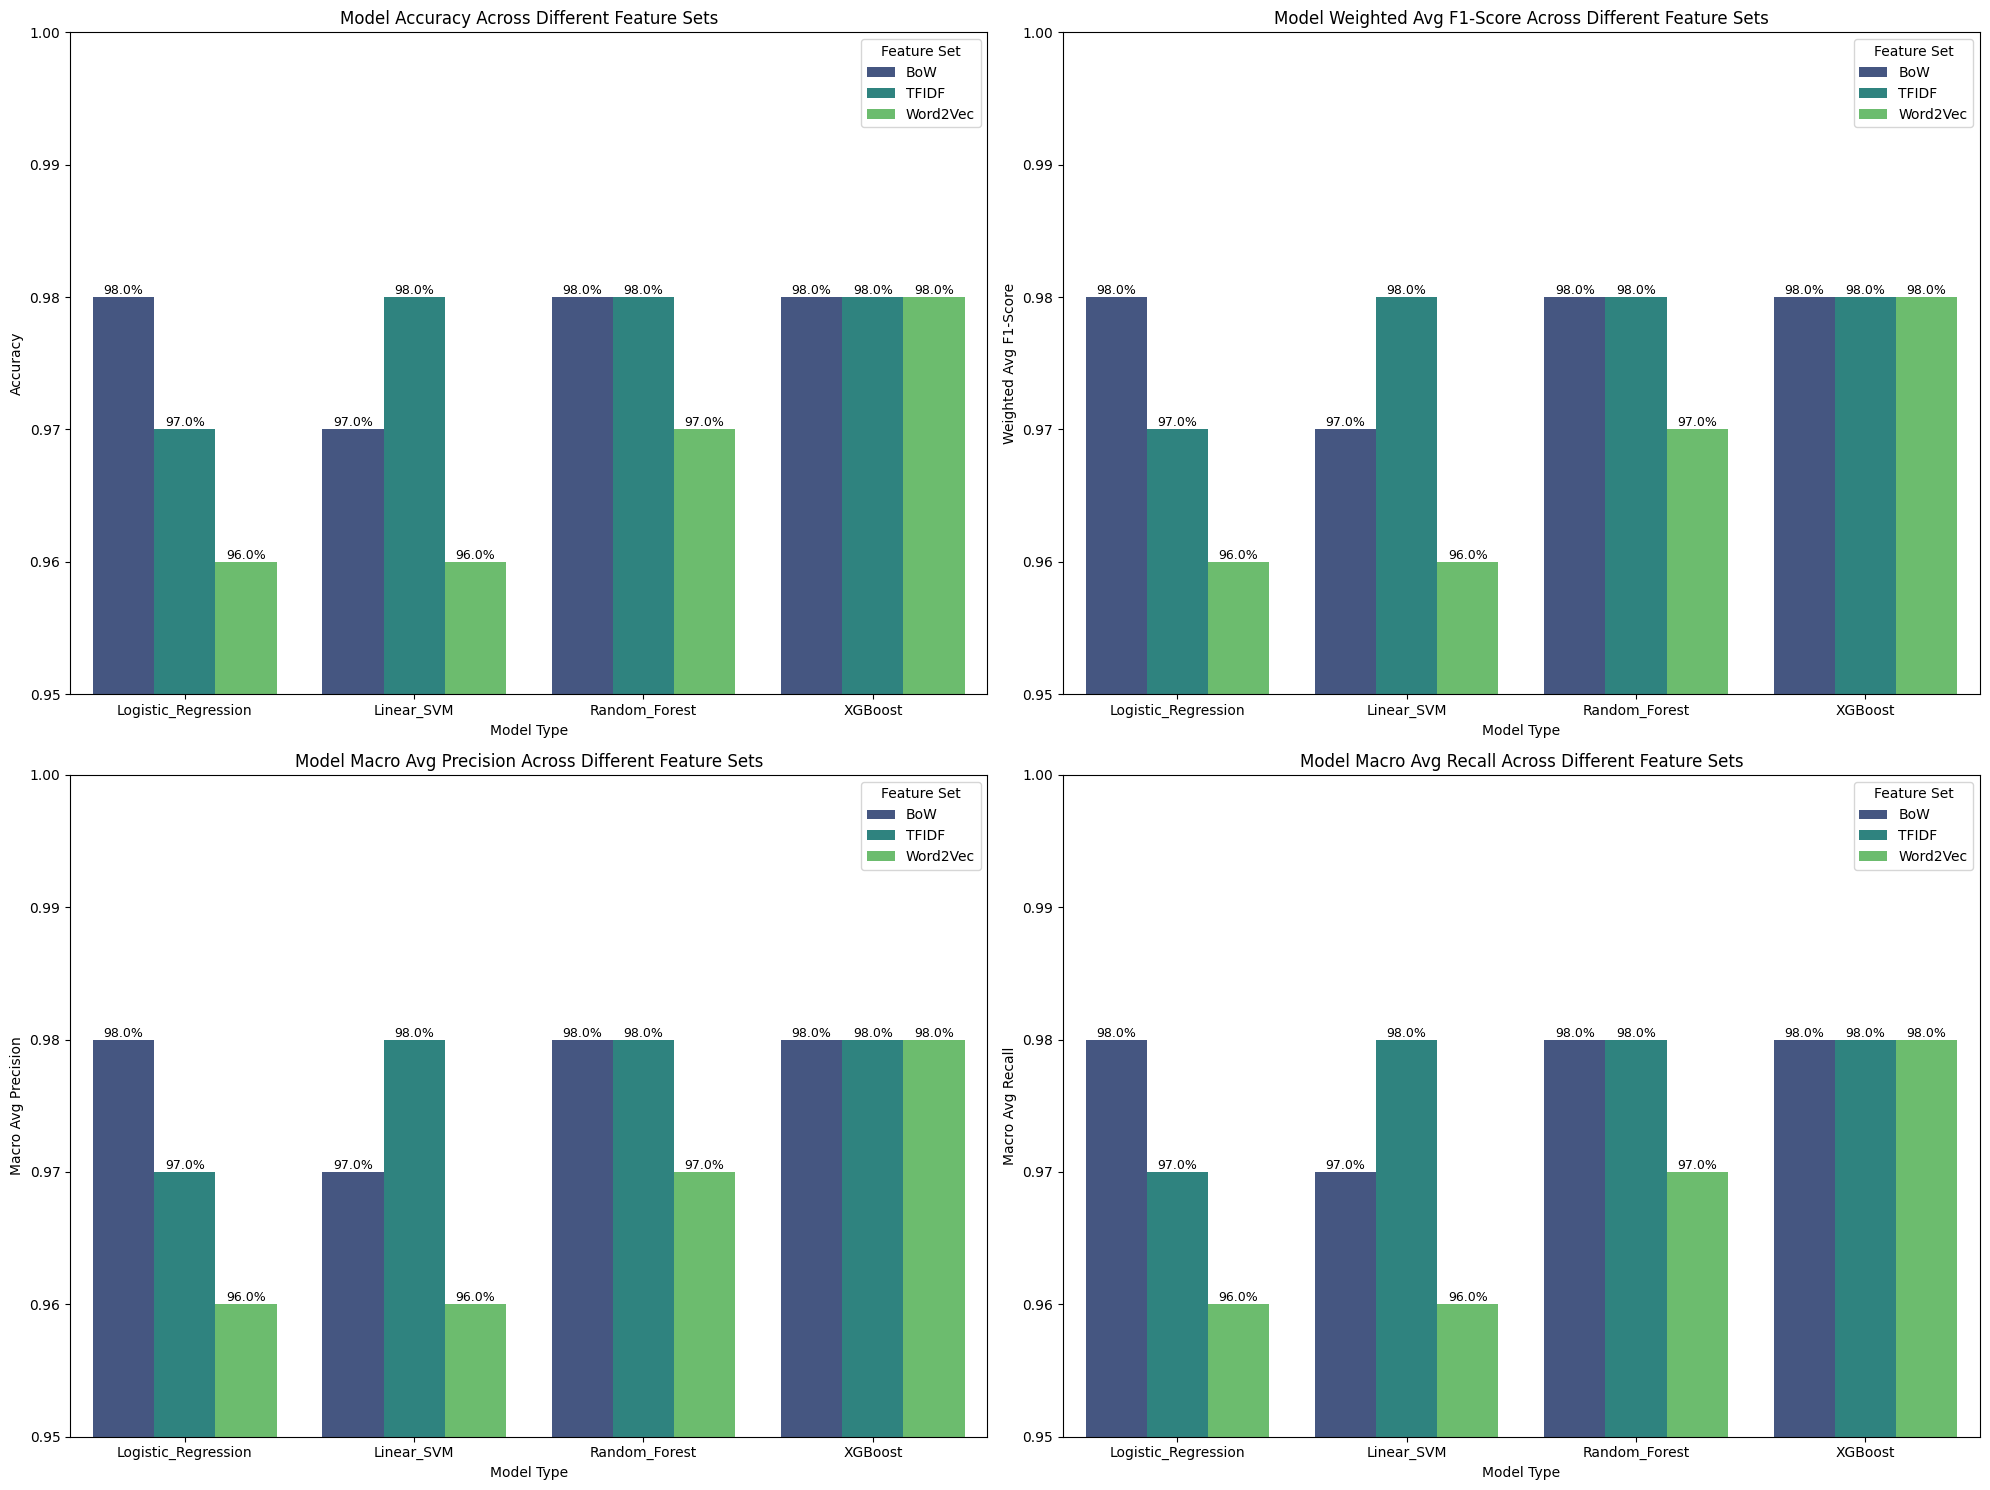

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_to_plot = [
    'Accuracy',
    'Weighted Avg F1-Score',
    'Macro Avg Precision',
    'Macro Avg Recall'
]

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten() # Flatten the 2x2 array of axes for easier iteration

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(data=df_performance, x='Model', y=metric, hue='Feature Set', palette='viridis', ax=axes[i])
    axes[i].set_title(f'Model {metric} Across Different Feature Sets')
    axes[i].set_xlabel('Model Type')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0.95, 1.0) # Consistent y-axis limit for better comparison
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].legend(title='Feature Set')

    # Add value labels on top of bars
    for container in axes[i].containers:
        for patch in container.patches:
            height = patch.get_height()
            if height > 0: # Only label bars with positive height
                axes[i].text(patch.get_x() + patch.get_width() / 2.,
                              height,
                              f'{height:.1%}', # Format as percentage
                              ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Prepare All Feature Sets Combined

### Subtask:
Combine the numerical features, Bag of Words (BoW) features, TF-IDF features, and aggregated Word2Vec features into a single, comprehensive dataset. This dataset (`X_all_combined`) will then be available for model training and evaluation.

**Reasoning**:
To create a single comprehensive dataset, I will use `np.hstack` to horizontally stack the `numerical_features`, `bow_features` (converted to dense array), `tfidf_features` (converted to dense array), and `word2vec_document_embeddings`. This will result in a wide array (`X_all_combined`) containing all engineered features.

In [ ]:
import numpy as np

# Ensure all sparse matrices are converted to dense arrays before stacking
X_all_combined = np.hstack((
    numerical_features.to_numpy(),
    bow_features.toarray(),
    tfidf_features.toarray(),
    word2vec_document_embeddings
))

print(f"Shape of X_all_combined: {X_all_combined.shape}")

Shape of X_all_combined: (20877, 76180)



Training Logistic Regression with BoW features...

Training Logistic Regression with TF-IDF features...

Training Logistic Regression with Word2Vec features...

Training Linear SVM with BoW features...

Training Linear SVM with TF-IDF features...

Training Linear SVM with Word2Vec features...

Training Random Forest with BoW features...

Training Random Forest with TF-IDF features...

Training Random Forest with Word2Vec features...

Training XGBoost with BoW features...

Training XGBoost with TF-IDF features...

Training XGBoost with Word2Vec features...


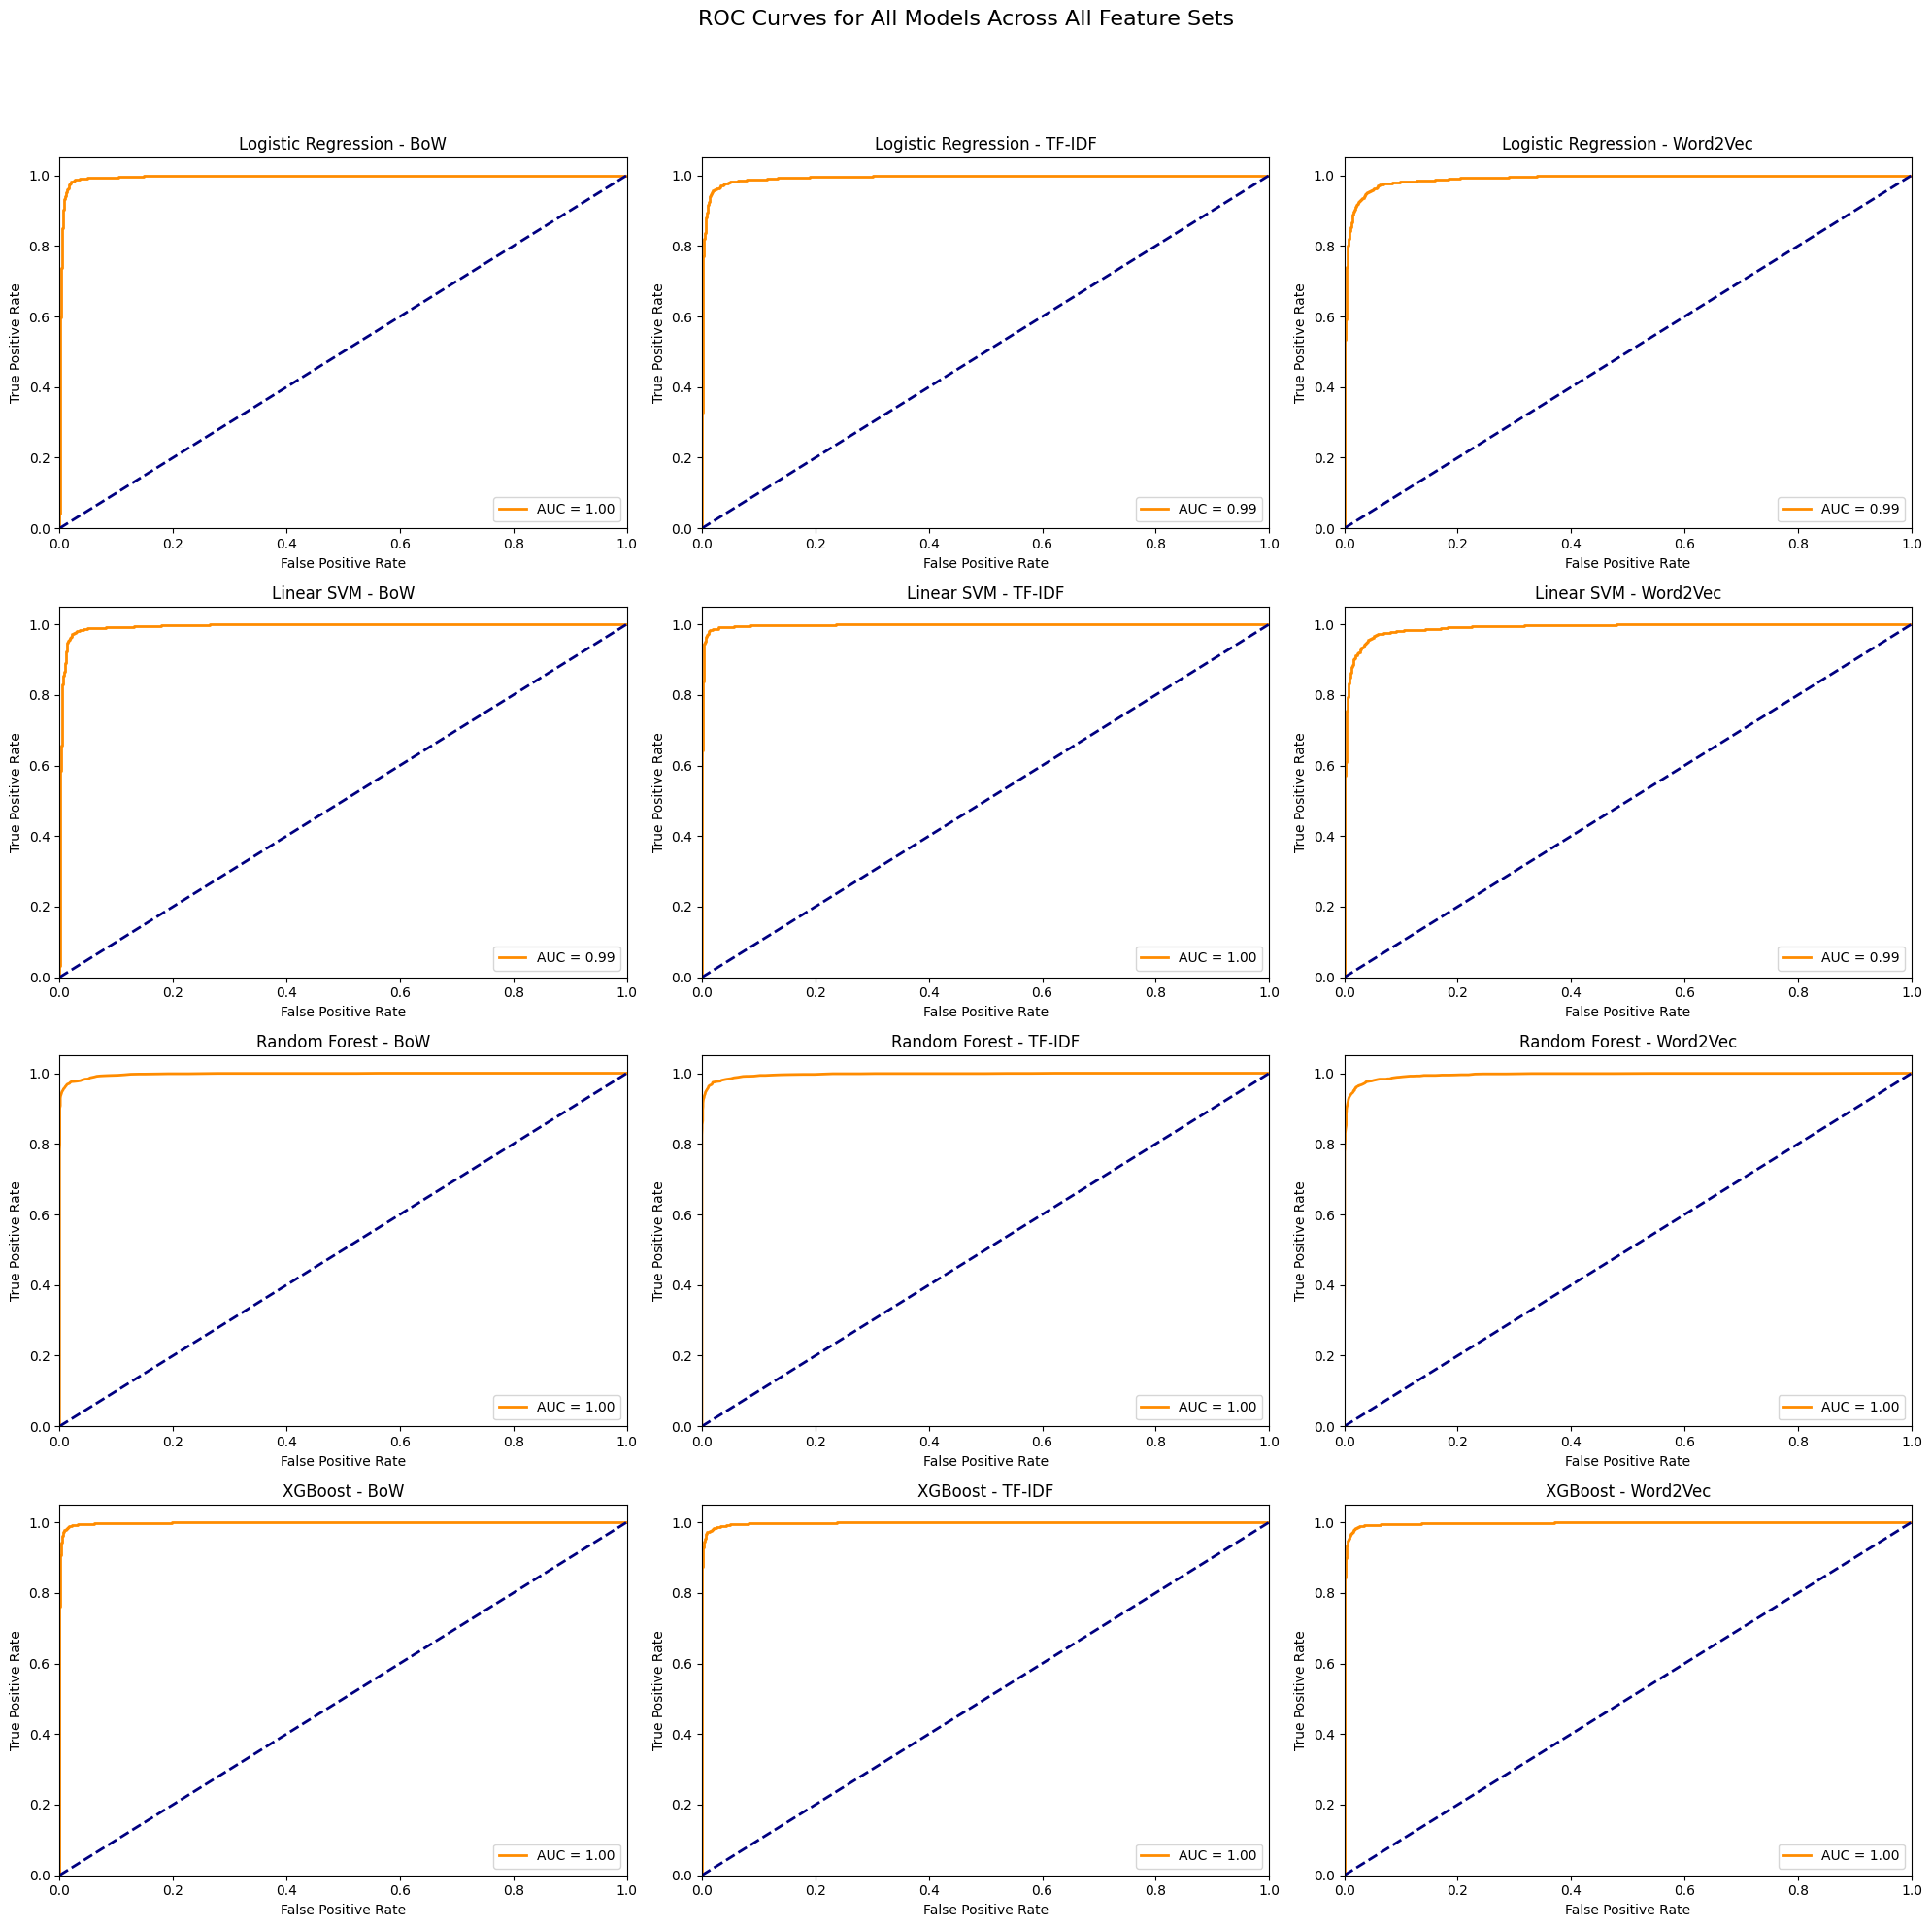

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np

# Define models with appropriate parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear'),
    'Linear SVM': LinearSVC(random_state=RANDOM_STATE, max_iter=2000, dual=False),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='logloss')
}

# Group feature sets and their corresponding data
feature_set_data = {
    'BoW': (X_train_bow, X_test_bow),
    'TF-IDF': (X_train_tfidf, X_test_tfidf),
    'Word2Vec': (X_train_word2vec, X_test_word2vec)
}

# Create a 4x3 subplot grid
fig, axes = plt.subplots(len(models), len(feature_set_data), figsize=(20, 20))
fig.suptitle('ROC Curves for All Models Across All Feature Sets', fontsize=16, y=1.02)

for i, (model_name, model) in enumerate(models.items()):
    for j, (fs_name, (X_train_fs, X_test_fs)) in enumerate(feature_set_data.items()):
        ax = axes[i, j]

        print(f"\nTraining {model_name} with {fs_name} features...")
        # Train the model
        model.fit(X_train_fs, y_train)

        # Get predictions
        if hasattr(model, 'predict_proba'): # For models that output probabilities
            y_pred_proba = model.predict_proba(X_test_fs)[:, 1]
        elif hasattr(model, 'decision_function'): # For LinearSVC
            y_pred_proba = model.decision_function(X_test_fs)
        else:
            # Fallback for models without direct probability or decision function (unlikely for these)
            y_pred_proba = model.predict(X_test_fs)

        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{model_name} - {fs_name}')
        ax.legend(loc='lower right')

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()



Generating Confusion Matrix for Logistic Regression with BoW features...

Generating Confusion Matrix for Logistic Regression with TF-IDF features...

Generating Confusion Matrix for Logistic Regression with Word2Vec features...

Generating Confusion Matrix for Linear SVM with BoW features...

Generating Confusion Matrix for Linear SVM with TF-IDF features...

Generating Confusion Matrix for Linear SVM with Word2Vec features...

Generating Confusion Matrix for Random Forest with BoW features...

Generating Confusion Matrix for Random Forest with TF-IDF features...

Generating Confusion Matrix for Random Forest with Word2Vec features...

Generating Confusion Matrix for XGBoost with BoW features...

Generating Confusion Matrix for XGBoost with TF-IDF features...

Generating Confusion Matrix for XGBoost with Word2Vec features...


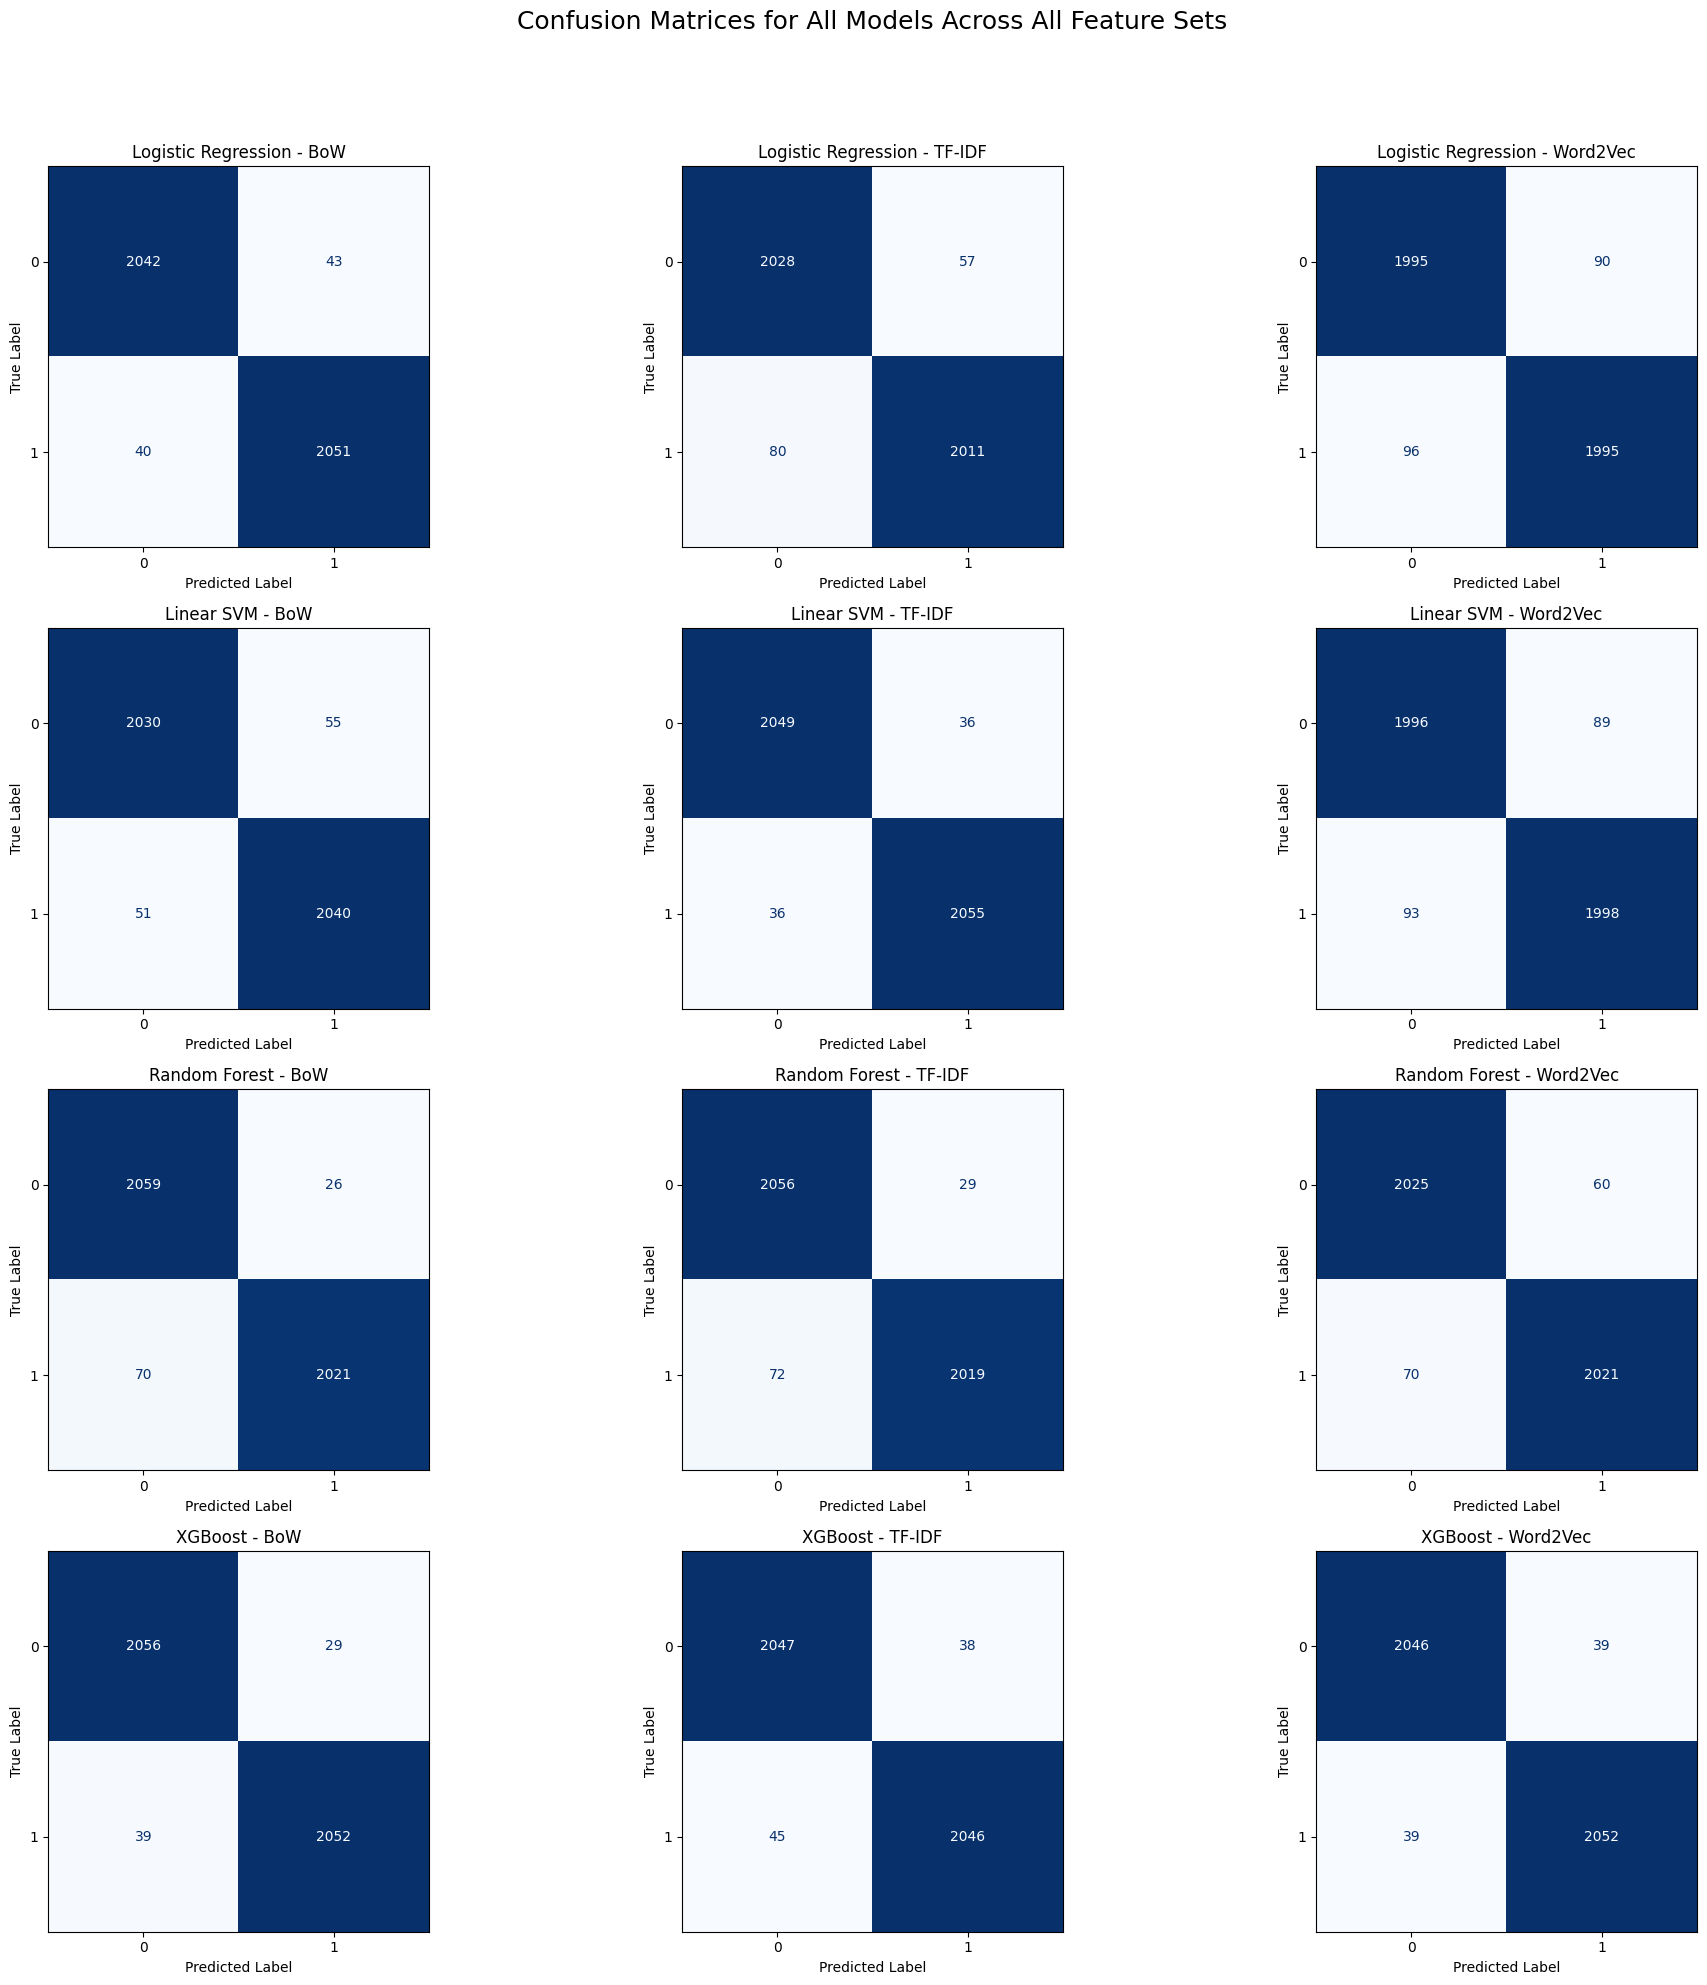

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np

# Define models with appropriate parameters (re-initializing them for plotting)
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear'),
    'Linear SVM': LinearSVC(random_state=RANDOM_STATE, max_iter=2000, dual=False),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='logloss')
}

# Group feature sets and their corresponding data
feature_set_data = {
    'BoW': (X_train_bow, X_test_bow),
    'TF-IDF': (X_train_tfidf, X_test_tfidf),
    'Word2Vec': (X_train_word2vec, X_test_word2vec).
}

# Create a 4x3 subplot grid for confusion matrices
fig, axes = plt.subplots(len(models), len(feature_set_data), figsize=(20, 20))
fig.suptitle('Confusion Matrices for All Models Across All Feature Sets', fontsize=18, y=1.02)

for i, (model_name, model) in enumerate(models.items()):
    for j, (fs_name, (X_train_fs, X_test_fs)) in enumerate(feature_set_data.items()):
        ax = axes[i, j]

        print(f"\nGenerating Confusion Matrix for {model_name} with {fs_name} features...")
        # Train the model (if not already trained from previous cells)
        model.fit(X_train_fs, y_train)

        # Make predictions
        y_pred = model.predict(X_test_fs)

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues', ax=ax, colorbar=False)
        ax.set_title(f'{model_name} - {fs_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()


I will save the three trained Logistic Regression models (for BoW, TF-IDF, and Word2Vec feature sets), three Linear SVM models (for BoW, TF-IDF, and Word2Vec feature sets), three Random Forest models (for BoW, TF-IDF, and Word2Vec feature sets), and three XGBoost models (for BoW, TF-IDF, and Word2Vec feature sets) using `joblib` to Google Drive. Then, I will confirm the presence of the `CountVectorizer` (`count_vectorizer.joblib`), `TfidfVectorizer` (`tfidf_vectorizer.joblib`), and `Word2Vec` model (`word2vec_model.bin`) in Google Drive and summarize all the saved model files and feature extractors.

I will now import `joblib` and then use `joblib.dump()` to save each model to the specified Google Drive path, followed by a confirmation message.



In [ ]:
import joblib

# Save Logistic Regression with BoW model
joblib.dump(logistic_model_bow, '/content/drive/My Drive/Human vs AI Generated Text Classification/logistic_model_bow.joblib')
print("Logistic Regression (BoW) model saved.")

# Save Logistic Regression with TF-IDF model
joblib.dump(logistic_model_tfidf, '/content/drive/My Drive/Human vs AI Generated Text Classification/logistic_model_tfidf.joblib')
print("Logistic Regression (TF-IDF) model saved.")

# Save Logistic Regression with Word2Vec model
joblib.dump(logistic_model_word2vec, '/content/drive/My Drive/Human vs AI Generated Text Classification/logistic_model_word2vec.joblib')
print("Logistic Regression (Word2Vec) model saved.")

print("All Logistic Regression models have been successfully saved to Google Drive.")

Logistic Regression (BoW) model saved.
Logistic Regression (TF-IDF) model saved.
Logistic Regression (Word2Vec) model saved.
All Logistic Regression models have been successfully saved to Google Drive.


I will now implement the saving of the three trained Linear SVM models (BoW, TF-IDF, and Word2Vec feature sets) to Google Drive using `joblib.dump()`.



In [ ]:
import joblib

# Save Linear SVM with BoW model
joblib.dump(svm_model_bow, '/content/drive/My Drive/Human vs AI Generated Text Classification/linear_svm_model_bow.joblib')
print("Linear SVM (BoW) model saved.")

# Save Linear SVM with TF-IDF model
joblib.dump(svm_model_tfidf, '/content/drive/My Drive/Human vs AI Generated Text Classification/linear_svm_model_tfidf.joblib')
print("Linear SVM (TF-IDF) model saved.")

# Save Linear SVM with Word2Vec model
joblib.dump(svm_model_word2vec, '/content/drive/My Drive/Human vs AI Generated Text Classification/linear_svm_model_word2vec.joblib')
print("Linear SVM (Word2Vec) model saved.")

print("All Linear SVM models have been successfully saved to Google Drive.")

Linear SVM (BoW) model saved.
Linear SVM (TF-IDF) model saved.
Linear SVM (Word2Vec) model saved.
All Linear SVM models have been successfully saved to Google Drive.


I will now implement the saving of the three trained Random Forest models (BoW, TF-IDF, and Word2Vec feature sets) to Google Drive using `joblib.dump()`, as specified in the instructions.



In [ ]:
import joblib

# Save Random Forest with BoW model
joblib.dump(rf_model_bow, '/content/drive/My Drive/Human vs AI Generated Text Classification/random_forest_model_bow.joblib')
print("Random Forest (BoW) model saved.")

# Save Random Forest with TF-IDF model
joblib.dump(rf_model_tfidf, '/content/drive/My Drive/Human vs AI Generated Text Classification/random_forest_model_tfidf.joblib')
print("Random Forest (TF-IDF) model saved.")

# Save Random Forest with Word2Vec model
joblib.dump(rf_model_word2vec, '/content/drive/My Drive/Human vs AI Generated Text Classification/random_forest_model_word2vec.joblib')
print("Random Forest (Word2Vec) model saved.")

print("All Random Forest models have been successfully saved to Google Drive.")

Random Forest (BoW) model saved.
Random Forest (TF-IDF) model saved.
Random Forest (Word2Vec) model saved.
All Random Forest models have been successfully saved to Google Drive.


I will now implement the saving of the three trained XGBoost models (BoW, TF-IDF, and Word2Vec feature sets) to Google Drive using `joblib.dump()`.



In [ ]:
import joblib

# Save XGBoost with BoW model
joblib.dump(xgb_model_bow, '/content/drive/My Drive/Human vs AI Generated Text Classification/xgboost_model_bow.joblib')
print("XGBoost (BoW) model saved.")

# Save XGBoost with TF-IDF model
joblib.dump(xgb_model_tfidf, '/content/drive/My Drive/Human vs AI Generated Text Classification/xgboost_model_tfidf.joblib')
print("XGBoost (TF-IDF) model saved.")

# Save XGBoost with Word2Vec model
joblib.dump(xgb_model_word2vec, '/content/drive/My Drive/Human vs AI Generated Text Classification/xgboost_model_word2vec.joblib')
print("XGBoost (Word2Vec) model saved.")

print("All XGBoost models have been successfully saved to Google Drive.")

XGBoost (BoW) model saved.
XGBoost (TF-IDF) model saved.
XGBoost (Word2Vec) model saved.
All XGBoost models have been successfully saved to Google Drive.


The previous step successfully saved all XGBoost models, completing the model saving portion of the task. The next part of the main task is to confirm the presence of the `CountVectorizer`, `TfidfVectorizer`, and `Word2Vec` model, which were saved in previous steps. I will use a shell command to list the contents of the Google Drive folder to visually confirm their presence, along with the newly saved models.



In [ ]:
import os

drive_path = '/content/drive/My Drive/Human vs AI Generated Text Classification/'
print(f"Listing contents of '{drive_path}':")
!ls -lh "{drive_path}"

print("Confirmation step for feature extractors and models completed.")

Listing contents of '/content/drive/My Drive/Human vs AI Generated Text Classification/':
total 1.1G
-rw------- 1 root root 106K Dec 12 14:26 1765533433232_96d2a190cc.csv
-rw------- 1 root root 779M Dec 17 01:26 AI_Human_balanced_dataset.csv
-rw------- 1 root root 508K Dec 26 21:59 count_vectorizer.joblib
-rw------- 1 root root 803K Dec 25 19:09 data_preprocessing.ipynb
-rw------- 1 root root  76K Dec 24 19:06 df_1_modified.csv
-rw------- 1 root root  64K Dec 24 19:09 df_2_modified.csv
-rw------- 1 root root  40M Dec 24 19:19 df_3_truncated.csv
-rw------- 1 root root  39M Dec 24 19:20 df_combined.csv
-rw------- 1 root root  38M Dec 24 19:30 df_combined_lemmatized.csv
-rw------- 1 root root  63M Dec 26 21:59 df_combined_lemmatized_feature_engineered.csv
-rw------- 1 root root 2.7M Dec 26 00:35 EDA.ipynb
-rw------- 1 root root  48K Dec 26 13:15 feature_engineering.ipynb
-rw------- 1 root root 298K Dec 26 22:49 linear_svm_model_bow.joblib
-rw------- 1 root root 298K Dec 26 22:49 linear_sv

## Summary:

The saved model files and feature extractors required for deploying the text classification system with Gradio are:
*   **Logistic Regression Models:**
    *   `logistic_model_bow.joblib`
    *   `logistic_model_tfidf.joblib`
    *   `logistic_model_word2vec.joblib`
*   **Linear SVM Models:**
    *   `linear_svm_model_bow.joblib`
    *   `linear_svm_model_tfidf.joblib`
    *   `linear_svm_model_word2vec.joblib`
*   **Random Forest Models:**
    *   `random_forest_model_bow.joblib`
    *   `random_forest_model_tfidf.joblib`
    *   `random_forest_model_word2vec.joblib`
*   **XGBoost Models:**
    *   `xgboost_model_bow.joblib`
    *   `xgboost_model_tfidf.joblib`
    *   `xgboost_model_word2vec.joblib`
*   **Feature Extractors:**
    *   `count_vectorizer.joblib`
    *   `tfidf_vectorizer.joblib`
    *   `word2vec_model.bin`

### Data Analysis Key Findings
*   A total of 12 machine learning models were successfully saved to Google Drive, comprising three models each for Logistic Regression, Linear SVM, Random Forest, and XGBoost, trained on BoW, TF-IDF, and Word2Vec feature sets.
*   All model files were saved using `joblib` in the specified directory `/content/drive/My Drive/Human vs AI Generated Text Classification/`.
*   The presence of all 12 saved model files, alongside the `CountVectorizer` (`count_vectorizer.joblib`), `TfidfVectorizer` (`tfidf_vectorizer.joblib`), and `Word2Vec` model (`word2vec_model.bin`), was confirmed in the Google Drive directory.